<h1 style="text-align:center;">AF3 prediction with a single TCR chain</h1>

In [97]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.PDB import MMCIFParser, PDBIO, PDBParser, Superimposer

# Infer TCR sequence
(we actually don't need that, Juliens AF3 script does that automatically)

In [45]:
# Construct lookup table
anno_dir = '/Users/roessner/Documents/PostDoc/Data/MixTCRviz/data_raw/HomoSapiens' # full sequences for VJ-segments
ref_csvs = glob.glob(f'{anno_dir}/*.csv')
ref_csvs.sort()

ref_tables = {}

for file in ref_csvs:
    name = os.path.basename(file).replace('.csv', '')  # e.g. TRAV
    df = pd.read_csv(file)
    df['full_clean'] = df['full'].str.replace(r'[-*]', '', regex=True)
    ref_tables[name] = df

lookup = {}

for gene_type, df in ref_tables.items():
    df = df.set_index('Unnamed: 0')
    
    lookup[gene_type] = {
        'full': df['full_clean'].to_dict(),
        'cdr3': df['CDR3'].to_dict()
    }

In [46]:
def reconstruct_chain(v_gene, j_gene, observed_cdr3, v_type, j_type):
    v_full = lookup[v_type]['full'][v_gene]
    v_ref_cdr3 = lookup[v_type]['cdr3'][v_gene]

    j_full = lookup[j_type]['full'][j_gene]
    j_ref_cdr3 = lookup[j_type]['cdr3'][j_gene]

    v_clean = v_full[:-len(v_ref_cdr3)]
    j_clean = j_full[len(j_ref_cdr3):]
    
    return v_clean + observed_cdr3 + j_clean


In [48]:
anno_dir = '/Users/roessner/Documents/PostDoc/Data/MixTCRviz/data_raw/HomoSapiens' # full sequences for VJ-segments

batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']
           
for batch in batches:
    batch_short = batch.split('/')[0]

    # originial data from julien containing V/J-segements + observed CDR3 sequences
    file = f"{batch.split('/')[1]}_AF3.tsv"
    df = pd.read_csv(file, sep='\t')[['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'cdr3_TRA', 'cdr3_TRB']]
    df = df.dropna()

    df['TRA_full'] = df.apply(
    lambda row: reconstruct_chain(
        row['TRAV'], row['TRAJ'], row['cdr3_TRA'],
        'TRAV', 'TRAJ'
    ),
    axis=1
)

    df['TRB_full'] = df.apply(
        lambda row: reconstruct_chain(
            row['TRBV'], row['TRBJ'], row['cdr3_TRB'],
            'TRBV', 'TRBJ'
        ),
        axis=1
    )

    df.to_csv(f'{batch_short}.csv', index=False)
    

# Prepare AF3 input

In [3]:
anno_dir = '/Users/roessner/Documents/PostDoc/Data/MixTCRviz/data_raw/HomoSapiens' # full sequences for VJ-segments

batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']    

for batch in batches:
    batch_short = batch.split('/')[0]

    # originial data from julien containing V/J-segements + observed CDR3 sequences
    file = f"{batch.split('/')[1]}_AF3.tsv"
    df = pd.read_csv(file, sep='\t')[['id', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'cdr3_TRA', 'cdr3_TRB']]
    df = df.dropna()
    df['peptide'] = 'LLWNGPMAV'
    df['MHC'] = 'HLA_A0201'
    df['species'] = 'HomoSapiens'
    
    df.to_csv(f'{batch_short}_AF3_input.csv', index=False)

    chains = ['A', 'B'] 
    for chain in chains:
        if chain == 'A':
            df_chain = df.drop(columns=['TRBV', 'TRBJ','cdr3_TRB'])
            df_chain.to_csv(f'{batch_short}_AF3_chainA_input.csv', index=False)
        else:
            df_chain = df.drop(columns=['TRAV', 'TRAJ','cdr3_TRA'])
            df_chain.to_csv(f'{batch_short}_AF3_chainB_input.csv', index=False)

        
    


# Compare ipTM double vs single chain

387


/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_29431/3334117781.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_chain = pd.read_csv(f'LAU5013_AF3_chain{chain}_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_29431/3334117781.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_chain = pd.read_csv(f'LAU5013_AF3_chain{chain}_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]


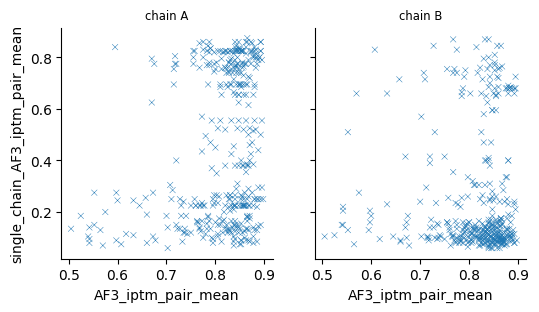

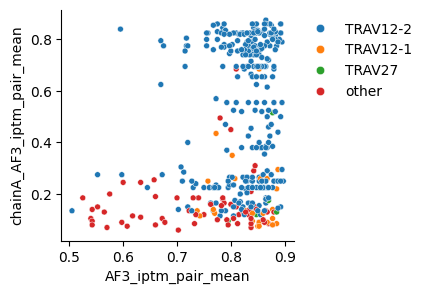

In [ ]:
topdir = "../260202_YF-modes/data_julien/LAU5013/YF_LAU5013_sc_WT"

threshold = 0.5

csv_file = glob.glob(f'{topdir}/*.csv')[0]
df = pd.read_csv(csv_file)
df = df[(df["TEMPOproblem"].isna()) & (df['AF3_iptm_pair_mean'] > threshold)]
df = df[['id', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'cdr3_TRA', 'cdr3_TRB', 'AF3_iptm_pair_mean']]
print(len(df))
chains = ['A', 'B']
for chain in chains:
    df_chain = pd.read_csv(f'LAU5013_AF3_chain{chain}_output.txt', delim_whitespace=True)[['id', 'AF3_iptm_pair_mean']]
    df_chain = df_chain.rename(columns={'AF3_iptm_pair_mean': f'chain{chain}_AF3_iptm_pair_mean'})

    # annotate sequence
    anno = pd.read_csv(f'LAU5013_AF3_chain{chain}_input.csv')
    anno = anno.drop(columns=['peptide', 'MHC', 'species'])
    
    df_chain = pd.merge(df_chain, anno, on='id')
    df_chain = df_chain.rename(columns={'id': f'chain{chain}_id'})

    # merge with original double chain data
    if chain == 'A':
        df = pd.merge(df, df_chain, how='left', on=['TRAV', 'TRAJ','cdr3_TRA'])
    else:
        df = pd.merge(df, df_chain, how='left', on=['TRBV', 'TRBJ','cdr3_TRB'])

df.to_pickle('AF3_double_and_single_chain.pkl')

lst = ['TRAV12-2', 'TRAV12-1', 'TRAV27']
df['tmp'] = np.where(df['TRAV'].isin(lst), df['TRAV'], 'other')

fig, axes = plt.subplots(1,2,figsize=(6,3), sharex=True, sharey=True)

for cnt, chain in enumerate(chains):
    ax = axes[cnt]
    sns.scatterplot(df, x='AF3_iptm_pair_mean', y=f'chain{chain}_AF3_iptm_pair_mean', ax=ax, marker='x', size=10, legend=False)
    ax.set_title(f'chain {chain}', fontsize='small')
    ax.set_ylabel('single_chain_AF3_iptm_pair_mean')

sns.despine()

order = ['TRAV12-2', 'TRAV12-1', 'TRAV27', 'other']
df['tmp'] = pd.Categorical(df['tmp'], categories=order, ordered=True)
df_sorted = df.sort_values('tmp')

fig, ax = plt.subplots(1,1,figsize=(3,3), sharex=True, sharey=True)
sns.scatterplot(df, x='AF3_iptm_pair_mean', y=f'chainA_AF3_iptm_pair_mean', hue='tmp', ax=ax, size=5)

handles, labels = ax.get_legend_handles_labels()
handles = handles[:-1]
labels = labels[:-1]
ax.legend(handles, labels, frameon=False, bbox_to_anchor=(1,1), title='')

sns.despine()

# RMSD douple vs single chain

In [104]:
# rename chains and export as pdb
chain_map = {'MHC' : 'A',
             'TCRA' : 'B',
             'TCRB' : 'C',
             'OTHER' : 'D',
             'PEPTIDE' : 'E'}

tcr_chains = ['A', 'B']
for chain in tcr_chains:
    topdir = f'LAU5013_AF3_chain{chain}/AF3_outputs'
    out_dir = f'{topdir}/model_pdb'
    os.makedirs(out_dir, exist_ok=True)

    files = glob.glob(f'{topdir}/*/*.cif')
    files.sort()
    
    parser = MMCIFParser(QUIET=True)
    for file in files:
        structure = parser.get_structure("structure", file)

        # Rename chains
        for model in structure:
            for chain in model:
                if chain.id in chain_map:
                    chain.id = chain_map[chain.id]

        # Output filename
        output_pdb = f'{out_dir}/{os.path.splitext(os.path.basename(file))[0]}.pdb'

        io = PDBIO()
        io.set_structure(structure)
        io.save(output_pdb)


In [115]:
def get_ca_atoms(structure, chain_id, start=None, end=None):
    atoms = []
    for model in structure:
        chain = model[chain_id]
        for residue in chain:
            res_id = residue.get_id()[1]  # residue number

            if start is not None and end is not None:
                if not (start <= res_id <= end):
                    continue

            if 'CA' in residue:
                atoms.append(residue['CA'])
    return atoms


In [130]:
df = pd.read_pickle('AF3_double_and_single_chain.pkl')

chains = ['A', 'B']
for chain in chains:
    df[f'chain{chain}_rmsd'] = np.nan

parser = PDBParser(QUIET=True)

for idx, row in df.iterrows():

    topdir_double = '../260202_YF-modes/data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align'
    ref_file = f'{topdir_double}/{row["id"]}.pdb'
    ref_structure = parser.get_structure("ref", ref_file)

    for chain in chains:

        topdir_chain = f'LAU5013_AF3_chain{chain}/AF3_outputs/model_pdb'
        mobile_file = f'{topdir_chain}/{row[f"chain{chain}_id"]}_model.pdb'
        mobile_structure = parser.get_structure("mobile", mobile_file)

        # align on MHC CA atoms
        ref_align_atoms = get_ca_atoms(ref_structure, 'A', start=25, end=205)
        mobile_align_atoms = get_ca_atoms(mobile_structure, 'A', start=25, end=205)

        sup = Superimposer()
        sup.set_atoms(ref_align_atoms, mobile_align_atoms)
        sup.apply(mobile_structure.get_atoms())

        # compute RMSD on CA atoms of TCR chain
        target_chain = 'B' if chain == 'A' else 'C'

        ref_target_atoms = get_ca_atoms(ref_structure, target_chain)
        mobile_target_atoms = get_ca_atoms(mobile_structure, target_chain)

        ref_coords = np.array([atom.coord for atom in ref_target_atoms])
        mobile_coords = np.array([atom.coord for atom in mobile_target_atoms])

        rmsd = np.sqrt(np.mean(np.sum((ref_coords - mobile_coords) ** 2, axis=1))) # sum of x, y, z and mean over all atoms

        df.at[idx, f'chain{chain}_rmsd'] = rmsd

df.to_pickle('AF3_double_and_single_chain_rmsd.pkl')


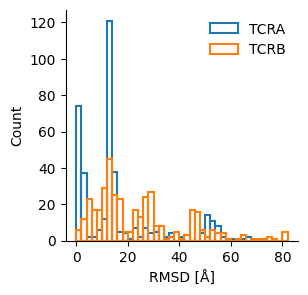

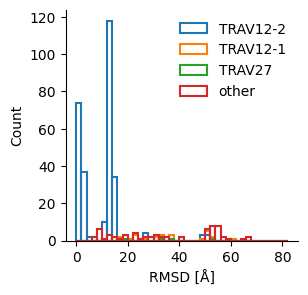

In [156]:
df = pd.read_pickle('AF3_double_and_single_chain_rmsd.pkl')

fig, ax = plt.subplots(1,1,figsize=(3,3))

bin_edges = np.arange(0, df[['chainA_rmsd','chainB_rmsd']].max().max() + 2, 2)

sns.histplot(df, x='chainA_rmsd', ax=ax, bins=bin_edges, label='TCRA', fill=False, linewidth=1.5)
sns.histplot(df, x='chainB_rmsd', ax=ax, bins=bin_edges, label='TCRB', fill=False, linewidth=1.5)
ax.set_xlabel('RMSD [Å]')
ax.legend(loc='upper right', frameon=False)
sns.despine()

fig, ax = plt.subplots(1,1,figsize=(3,3))

lst = ['TRAV12-2', 'TRAV12-1', 'TRAV27']
df['tmp'] = np.where(df['TRAV'].isin(lst), df['TRAV'], 'other')

genes = ['TRAV12-2', 'TRAV12-1', 'TRAV27', 'other']
for gene in genes:
    tmp = df[df['tmp'] == gene]
    sns.histplot(tmp, x='chainA_rmsd', ax=ax, bins=bin_edges, fill=False, linewidth=1.5, label=gene)
ax.set_xlabel('RMSD [Å]')
ax.legend(loc='upper right', frameon=False)
sns.despine()

In [127]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms

u_ref = mda.Universe("../260202_YF-modes/data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align/tcr0001.pdb")
u_mob = mda.Universe("/Users/roessner/Downloads/chain_A_tcr0001.pdb")

# Select atoms (example: CA atoms of chain A)
ref_atoms = u_ref.select_atoms("segid B and name CA").positions
mob_atoms = u_mob.select_atoms("segid B and name CA").positions

diff = ref_atoms - mob_atoms
sq_dist = np.sum(diff**2, axis=1)
rmsd = np.sqrt(np.mean(sq_dist))
print(rmsd)

1.0074997
